# Jupiter XIIe Lustrum - Text Analytics

In [223]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import pandas as pd
import datetime as dt

import nltk
from nltk.probability import FreqDist

import sys
import codecs
import nltk
from nltk.corpus import stopwords

import random
import matplotlib as mpl

from scipy.misc import imread
from wordcloud import WordCloud, STOPWORDS


In [216]:
# Import data Simon since 2013
df = pd.read_table('./data_2013.txt', names=["all"])
#df = pd.read_table('./data_2014.txt', names=["all"]

# Extract date from messages with regex
df['date'] = df['all'].str.extract("(\d{1,2}/\d{2}/\d{2}, \d{2}:\d{2})", expand=True)

# Parse date as datetime. format: 3/25/13, 14:20
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%y, %H:%M')

# Extract name and message
df['name'] = df['all'].str.extract("(\d{1,2}/\d{2}/\d{2}, \d{2}:\d{2})( -.*?:)(.*)", expand=True)[1].str[3:-1]
df['message'] = df['all'].str.extract("(\d{1,2}/\d{2}/\d{2}, \d{2}:\d{2})( -.*?:)(.*)", expand=True)[2]
df = df.drop('all', 1)

# Include weekday name and hour of day
df['weekday'] = df['date'].dt.weekday_name
df['dayhour'] = df['date'].dt.hour

# Drop missing data 
df = df.dropna()

# Tokenize words
df["tokenized_mess"] = df["message"].apply(nltk.word_tokenize)
df['mess_length'] = df.apply(lambda row: len(row['tokenized_mess']), axis=1)

In [217]:
def nr_message_plot(df, groupby_col):
    df.groupby(groupby_col).size().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title="Nr. of messages whole group")

def name_nr_message_plot(df, name, groupby_col):
    df[df['name'] == name].groupby(groupby_col).size().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title="Nr. of messages %s" % name)

def message_length_plot(df):
    df.groupby('name')['mess_length'].mean().sort_values(ascending=False).\
    plot.bar(alpha=0.5, title="Average message length")
    
def name_message_length_plot(df, name, groupby_col):
    df[df['name'] == name].groupby('dayhour')['mess_length'].mean().\
    sort_values(ascending=False).plot.bar(alpha=0.5, title="Average message length %s" % name)    

In [225]:
def name_wordcloud(df, name):
    # Join the messages per name 
    dfn = df.groupby(['name'])['message'].apply(lambda x: ','.join(x)).reset_index()
    text = str(dfn.loc[(dfn['name'] == name),'message'].values)
    
    # Verneuk-parameter 
    verneuk = ""
    text = text + verneuk*50
    
    # NLTK's default Dutch stopwords
    default_stopwords = set(nltk.corpus.stopwords.words('dutch'))

    # We're adding some on our own - could be done inline like this...
    custom_stopwords = set((u'omitted', u'media', u'wel', u'even', u'we', u'haha'))
    # ... but let's read them from a file instead (one stopword per line, UTF-8)
    #stopwords_file = './stopwords.txt'
    #custom_stopwords = set(codecs.open(stopwords_file, 'r', 'utf-8').read().splitlines())

    all_stopwords = default_stopwords | custom_stopwords

    words = nltk.tokenize.word_tokenize(text)

    # Remove single-character tokens (mostly punctuation)
    words = [word for word in words if len(word) > 1]

    # Remove numbers
    words = [word for word in words if not word.isnumeric()]

    # Lowercase all words (default_stopwords are lowercase too)
    words = [word.lower() for word in words]

    # Stemming words seems to make matters worse, disabled
    # stemmer = nltk.stem.snowball.SnowballStemmer('german')
    # words = [stemmer.stem(word) for word in words]

    # Remove stopwords
    words = [word for word in words if word not in all_stopwords]

    # Calculate frequency distribution
    fdist = nltk.FreqDist(words)

    # Output top 50 words
    #     for word, frequency in fdist.most_common(50):
    #         print(u'{};{}'.format(word, frequency))
    
    # Initialize wordcloud parameters
    limit = 1000
    bgcolor = '#000000'
    fontcolor='#fafafa'
    
    # Generate wordcloud
    wordcloud = WordCloud(
    max_words=limit,
    stopwords=all_stopwords,
    background_color=bgcolor
    ).generate(text)
    
    # Plot wordcloud
    fig = plt.figure()
    fig.set_figwidth(8)
    fig.set_figheight(6)

    plt.imshow(wordcloud.recolor(color_func=grey_color,  random_state=3))

    plt.title("dikke lul", color=fontcolor, size=30, y=1.01)
    plt.axis('off')
    plt.show()

def grey_color(word, font_size, position, orientation, random_state=None, **kwargs):
    return 'hsl(0, 0%%, %d%%)' % random.randint(50, 100)

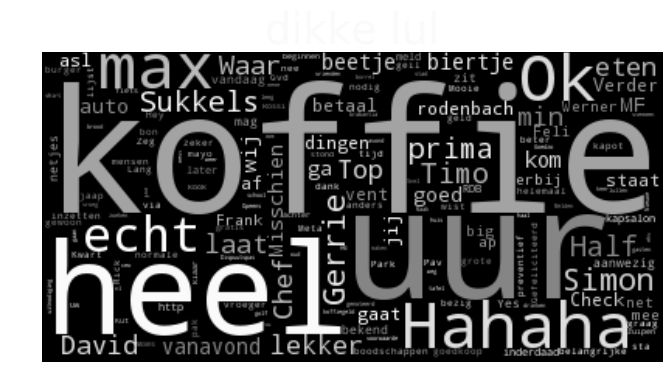

In [226]:
name_wordcloud(df, 'Job Visser')

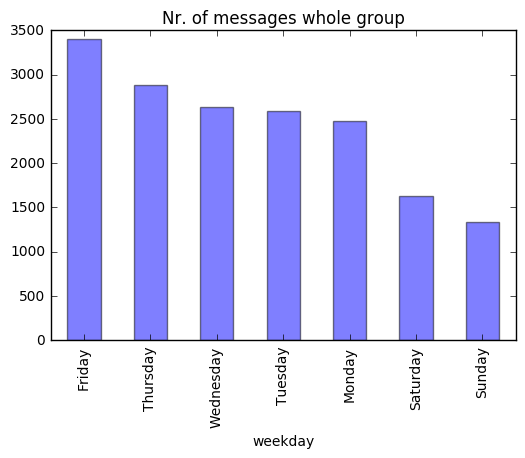

In [218]:
nr_message_plot(d, 'weekday')

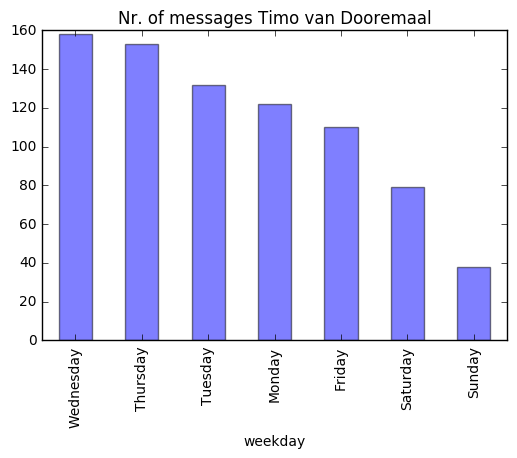

In [219]:
name_nr_message_plot(d, 'Timo van Dooremaal', 'weekday')

# TODO: Count emoticons

In [182]:
# Add Emoticon detection

import re

count = len(re.findall(r'[\U0001f600-\U0001f650]', d['message'].iloc[24174]))
count

0